In [14]:
# Titanic Survival Prediction using Random Forest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# 2. Loading the passenger lists

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [16]:
# 3. Getting to know data

print("Train shape:", train.shape) # How many passengers and details in the training set?
print("Test shape:", test.shape)   # And in the test set?
print("\nWhat kind of data is in each column?\n", train.dtypes)
print("\nWhere are the gaps in the training data?\n", train.isnull().sum())
print("\nWhere are the gaps in the test data?\n", test.isnull().sum())

# Peeking at the first few passengers to get a feel for the data
display(train.head())

# summary of  age, fare, etc.
display(train.describe())

Train shape: (891, 12)
Test shape: (418, 11)

What kind of data is in each column?
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Where are the gaps in the training data?
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Where are the gaps in the test data?
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


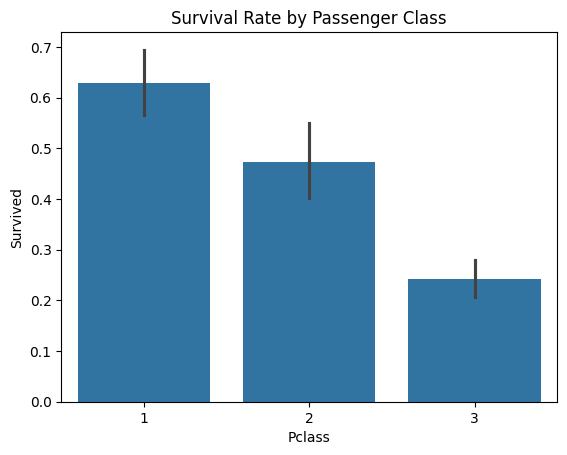

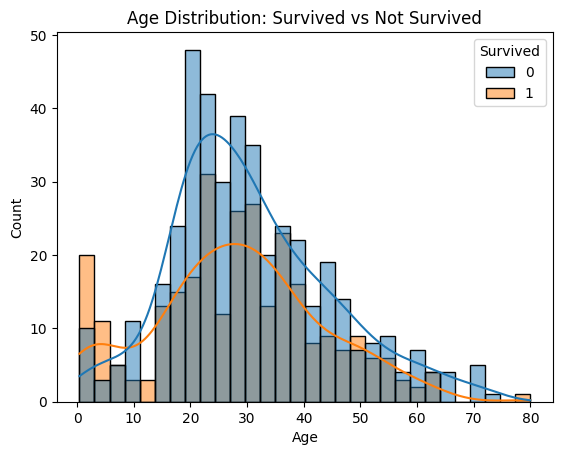

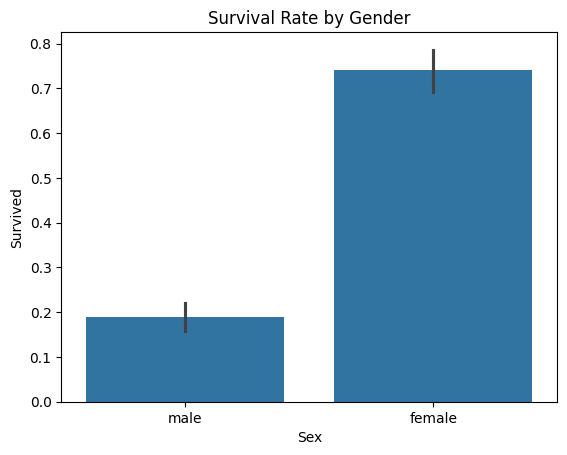

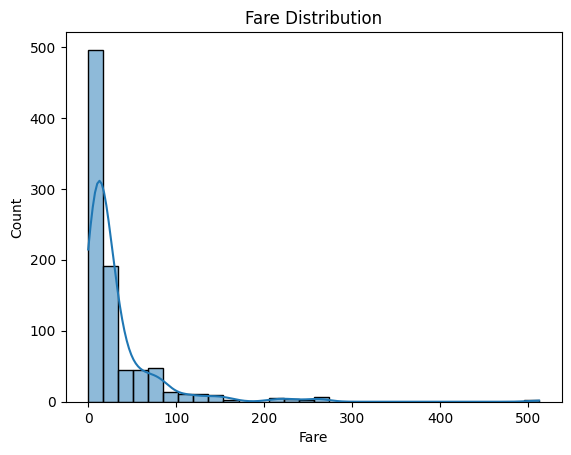

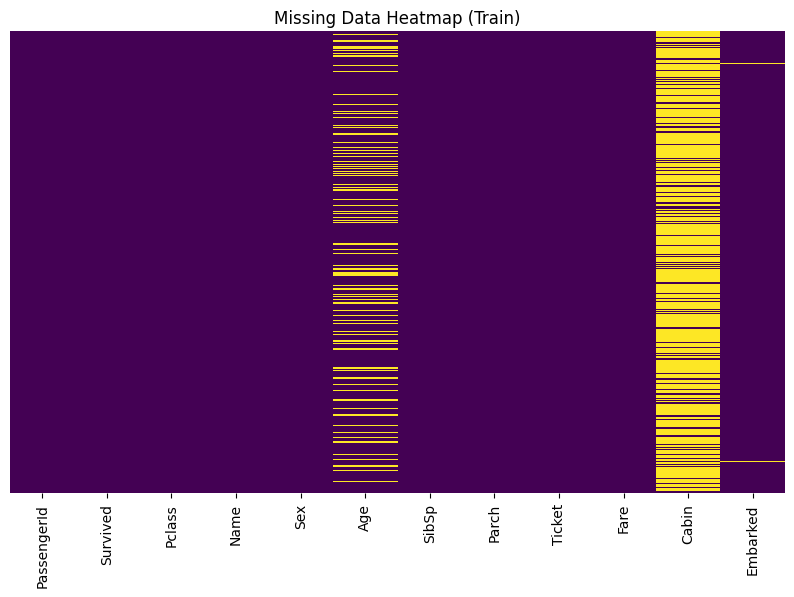

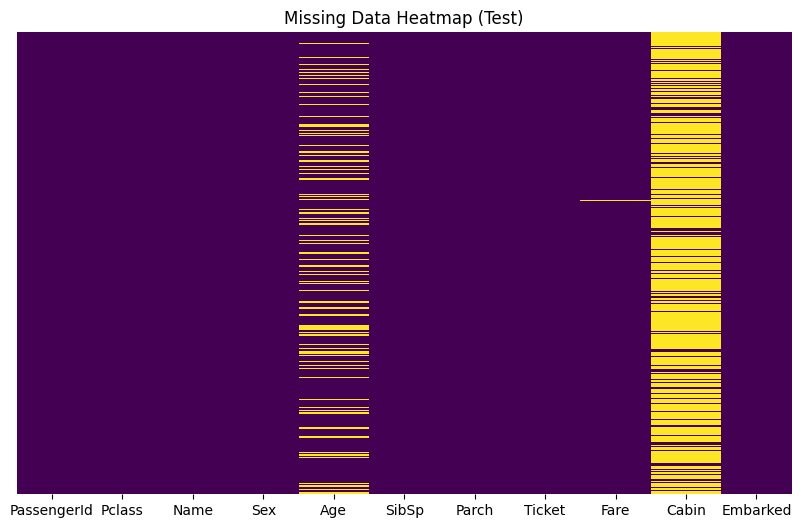

In [17]:
# 4. Visualizing patterns in the data

# ticket class affect your chances of survival
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Passenger Class')
plt.show()

# How does age relate to survival
sns.histplot(data=train, x='Age', hue='Survived', bins=30, kde=True)
plt.title('Age Distribution: Survived vs Not Survived')
plt.show()

#  men or women more likely to survive
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Gender')
plt.show()

# cost of the ticket distributed among passengers
sns.histplot(train['Fare'], bins=30, kde=True)
plt.title('Fare Distribution')
plt.show()

#   data  missing in the training set (yellow lines indicate missing values)
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap (Train)')
plt.show()

# data missing in the test set
plt.figure(figsize=(10, 6))
sns.heatmap(test.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap (Test)')
plt.show()

In [18]:
# 5 (Preprocessing)

# Filling in missing ages with the average age of passengers
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)

# Filling in where people got on the ship (Embarked) with the most common port
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)

# Filling in the single missing fare value in the test set with the median (only one missing)
test['Fare'].fillna(test['Fare'].median(), inplace=True)


# Creating a simple feature: cabin number listed? (1 for Yes, 0 for No)
train['HasCabin'] = train['Cabin'].notnull().astype(int)
test['HasCabin'] = test['Cabin'].notnull().astype(int)

# Extracting the title (Mr., Mrs., Miss, etc.) from the passenger's name
train['Title'] = train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False) # Using raw string for regex
test['Title'] = test['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False) # Using raw string for regex

# Grouping less common titles into a 'Rare' category
for dataset in [train, test]:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
      'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# Converting titles into numbers
title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5}
for dataset in [train, test]:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'].fillna(0, inplace=True) # Fill any titles that didn't map with 0

# Creating a feature for the size of the passenger's family on board
for dataset in [train, test]:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Putting ages into categories (like child, adult, etc.)
for dataset in [train, test]:
    dataset['AgeBin'] = pd.cut(dataset['Age'], bins=[0,12,18,35,60,80], labels=[0,1,2,3,4])

# Putting fares into categories based on price ranges
for dataset in [train, test]:
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4, labels=[0,1,2,3])

# Converting 'male' and 'female' to numbers (0 and 1)
for dataset in [train, test]:
    dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

# Converting the 'Embarked' port (C, Q, S) into separate 'yes/no' columns
train = pd.get_dummies(train, columns=['Embarked'], drop_first=True) # drop_first avoids multicollinearity
test = pd.get_dummies(test, columns=['Embarked'], drop_first=True)

# Removing columns we no longer need
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Age', 'Fare']
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

# Making sure the training and test sets have the exact same columns in the same order
train_cols = list(train.columns)
train_cols.remove('Survived') # We exclude the 'Survived' column from the training features
test_cols = list(test.columns)

# Finding any columns that are in one set but not the other
missing_in_test = set(train_cols) - set(test_cols)
missing_in_train = set(test_cols) - set(train_cols) # Should be empty if alignment worked

# Adding any missing columns to the test set and filling with 0 (important for one-hot encoded columns)
for c in missing_in_test:
    test[c] = 0

# Reordering the columns in the test set to match the training set
test = test[train_cols]


# Separating our data into the features (X) we'll use for prediction and the target (y) we want to predict
X = train.drop('Survived', axis=1)
y = train['Survived']
test_X = test.copy() # Keeping a copy of the processed test features

/tmp/ipython-input-3262737766.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
/tmp/ipython-input-3262737766.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [24]:
# 6. Building our own Decision Tree and Random Forest (from scratch!)
# This is where we create the logic for how our model makes decisions.

import random
from collections import Counter
import numpy as np # Ensure numpy is imported

class DecisionTree:
    """
    Our custom Decision Tree classifier for predicting survival (binary classification).
    It learns by splitting the data based on features.
    """
    def __init__(self, max_depth=None, min_samples_split=2, max_features=None):
        # Setting up the tree's parameters: how deep can it go, how many samples needed to split, etc.
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features # How many features to consider for the best split (for Random Forest)
        self.tree = None # This will hold the structure of our trained tree

    def gini_impurity(self, y):
        """
        Calculate Gini impurity for a set of labels.
        A lower number means the group is more 'pure' (mostly one class).
        """
        m = len(y)
        if m == 0:
            return 0 # If there's no data, impurity is 0
        counts = np.bincount(y) # Count occurrences of each class (0 and 1)
        probs = counts / m # Calculate the proportion of each class
        return 1 - np.sum(probs ** 2) # Gini impurity formula

    def information_gain(self, X, y, feature, threshold):
        """
        Calculate information gain from a split.
        Measures how much 'purity' we gain by splitting the data on a specific feature and threshold.
        """
        gini_parent = self.gini_impurity(y) # Impurity before the split

        left_idx = np.where(X[:, feature] <= threshold)[0] # Indices of samples less than or equal to the threshold
        right_idx = np.where(X[:, feature] > threshold)[0] # Indices of samples greater than the threshold

        n = len(y)
        n_left = len(left_idx) # Number of samples in the left split
        n_right = len(right_idx) # Number of samples in the right split

        if n_left == 0 or n_right == 0:
            return 0 # No gain if one side of the split is empty

        gini_left = self.gini_impurity(y[left_idx]) # Impurity in the left split
        gini_right = self.gini_impurity(y[right_idx]) # Impurity in the right split

        weighted_gini = (n_left / n) * gini_left + (n_right / n) * gini_right # Weighted average impurity after split
        return gini_parent - weighted_gini # Information gain is the reduction in impurity


    def best_split(self, X, y):
        """
        Find the best feature and threshold to split on.
        It tries different features and thresholds to find the one that gives the most information gain.
        """
        best_gain = -1 # Start with a low gain
        split_feature, split_threshold = None, None # Initialize the best split found
        num_features = X.shape[1]

        # Select random subset of features if max_features is set
        if self.max_features:
            features_to_consider = random.sample(range(num_features), self.max_features)
        else:
            features_to_consider = range(num_features) # Consider all features if max_features is not set


        for feature in features_to_consider: # Look at each selected feature
            values = X[:, feature] # Get all values for this feature
            thresholds = np.unique(values) # Consider unique values as potential split points
            for threshold in thresholds: # For each potential split point
                gain = self.information_gain(X, y, feature, threshold) # Calculate gain for this split
                if gain > best_gain: # If this split is better than the best so far
                    best_gain = gain # Update the best gain
                    split_feature = feature # Remember which feature was best
                    split_threshold = threshold # Remember the best threshold
        return split_feature, split_threshold # Return the best feature and threshold for splitting


    def split_data(self, X, y, feature, threshold):
        """
        Split data based on feature and threshold.
        Returns the subsets of X and y for the left and right branches.
        """
        left_idx = np.where(X[:, feature] <= threshold)[0]
        right_idx = np.where(X[:, feature] > threshold)[0]
        return X[left_idx, :], y[left_idx], X[right_idx, :], y[right_idx]


    def fit(self, X, y):
        """
        Build the decision tree.
        Starts the recursive process of splitting the data.
        """
        self.tree = self._build_tree(X, y, 0) # Start building from depth 0

    def _build_tree(self, X, y, depth):
        """
        Recursive function to build the decision tree.
        """
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Stopping conditions:
        # 1. We've reached the maximum allowed depth of the tree.
        # 2. All samples in this group belong to the same class (pure node).
        # 3. The number of samples in this group is less than the minimum needed to split.
        if (self.max_depth is not None and depth >= self.max_depth) or (num_labels == 1) or (num_samples < self.min_samples_split):
            if len(y) == 0:  # Handle empty split gracefully
                return None # Indicate that this branch is empty
            leaf_value = Counter(y).most_common(1)[0][0] # Determine the majority class in this group
            return leaf_value # This node becomes a leaf predicting the majority class

        best_feature, best_threshold = self.best_split(X, y) # Find the best split for this group

        if best_feature is None: # If no good split was found
            if len(y) == 0: # Handle empty split
                 return None
            leaf_value = Counter(y).most_common(1)[0][0] # This node becomes a leaf predicting the majority class
            return leaf_value


        # Split the data based on the best feature and threshold found
        X_left, y_left, X_right, y_right = self.split_data(X, y, best_feature, best_threshold)

        # Recursively build the left and right subtrees
        left_subtree_result = self._build_tree(X_left, y_left, depth + 1)
        right_subtree_result = self._build_tree(X_right, y_right, depth + 1)

        # Handle cases where a subtree is None (from an empty split)
        if left_subtree_result is None and right_subtree_result is None:
            if len(y) == 0:
                 return None
            return Counter(y).most_common(1)[0][0]
        elif left_subtree_result is None:
             return right_subtree_result
        elif right_subtree_result is None:
             return left_subtree_result


        # Return the structure of this node: the split feature, threshold, and the left/right subtrees
        return (best_feature, best_threshold, left_subtree_result, right_subtree_result)


    def predict_sample(self, x):
        """
        Predict class for a single sample.
        It traverses the tree by following the split conditions based on the passenger's features.
        """
        tree = self.tree # Start from the root of the tree
        while isinstance(tree, tuple):
            feature, threshold, left, right = tree # Unpack the current node's information
            if x[feature] <= threshold:
                tree = left # Go down the left branch
            else:
                tree = right # Go down the right branch
        return tree # Return the predicted class at the leaf node


    def predict(self, X):
        """
        Predict classes for multiple samples.
        It calls predict_sample for each passenger in the input data.
        """
        return np.array([self.predict_sample(x) for x in X]) # Apply predict_sample to each row


class RandomForest:
    """
    Our custom Random Forest classifier. It's an ensemble of multiple Decision Trees.
    It makes predictions by combining the predictions of individual trees (majority vote).
    """
    def __init__(self, n_estimators=100, max_depth=None, min_samples_split=2, max_features='sqrt'):
        # Setting up the Random Forest parameters: number of trees, max depth for each tree, etc.
        self.n_estimators = n_estimators # How many trees to build
        self.max_depth = max_depth # Maximum depth for each individual tree
        self.min_samples_split = min_samples_split # Minimum samples required to split a node in each tree
        self.max_features = max_features # Number of features to consider for splitting in each tree
        self.trees = [] # This list will hold all the trained Decision Tree models

    def bootstrap_sample(self, X, y):
        """
        Create bootstrap samples.
        Creates a random sample of the data with replacement (bootstrapping).
        Each tree in the forest is trained on a different bootstrap sample.
        """
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True) # Randomly pick indices with replacement
        return X[idxs], y[idxs] # Return the sampled data and labels

    def random_feature_selection(self, n_features):
         """
         Select random subset of features.
         Determines how many features each tree should randomly consider at each split.
         Common options are 'sqrt' (square root of total features) or 'log2'.
         """
         if self.max_features == 'sqrt':
             return max(1, int(np.sqrt(n_features))) # Use the square root of the total number of features
         elif self.max_features == 'log2':
             return max(1, int(np.log2(n_features))) # Use the base-2 logarithm of the total number of features
         elif isinstance(self.max_features, int):
             return self.max_features # Use a fixed number of features if specified
         else:
             return n_features # Use all features if no method is specified


    def fit(self, X, y):
        """
        Train multiple decision trees.
        Trains the Random Forest by building multiple Decision Trees on bootstrap samples.
        """
        self.trees = [] # Clear any existing trees
        n_features = X.shape[1] # Total number of features
        max_feats = self.random_feature_selection(n_features) # Determine the number of features for each tree
        for _ in range(self.n_estimators): # Build the specified number of trees
            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=max_feats # Use the calculated number of features
            )
            X_samp, y_samp = self.bootstrap_sample(X, y) # Get a random sample of the data
            tree.fit(X_samp, y_samp) # Train the tree on the sampled data
            if tree.tree is not None: # Only append if tree is not None
                self.trees.append(tree) # Add the trained tree to our forest

    def predict(self, X):
        """
        Make predictions using majority voting.
        Predicts the class for a group of passengers using the trained Random Forest.
        It gets predictions from each tree and takes a majority vote.
        """
        tree_preds = np.array([tree.predict(X) for tree in self.trees]) # Get predictions from all trees
        # For each passenger, count the votes from all trees and pick the class with the most votes
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_preds)

    def predict_proba(self, X):
        """
        Return prediction probabilities.
        Predicts the probability of belonging to class 1 (survival) for a group of passengers.
        It calculates the fraction of trees that predicted class 1.
        """
        tree_preds = np.array([tree.predict(X) for tree in self.trees]) # Get predictions from all trees
        return np.mean(tree_preds, axis=0) # Calculate the average prediction (fraction of 1s) for each passenger

In [25]:
# 7. Evaluating our model
# Now that our Random Forest is built, let's see how well it performs.

from sklearn.model_selection import train_test_split # A standard tool for splitting data

# Convert DataFrame to numpy arrays for faster computation
X_np = X.values.astype(float)
y_np = y.values.astype(int)
X_train, X_val, y_train, y_val = train_test_split(X_np, y_np, test_size=0.2, random_state=42) # 80% for training, 20% for validation

# Train the Random Forest
# Increased n_estimators slightly for potentially better results
rf = RandomForest(n_estimators=20, max_depth=5, min_samples_split=2, max_features='sqrt') # Setting up the forest
rf.fit(X_train, y_train) # Let the training begin!

# Predict on validation set
y_pred = rf.predict(X_val)

# Accuracy calculation
def accuracy(y_true, y_pred):
    # Compares the true survival status to our model's predictions
    return np.sum(y_true == y_pred) / len(y_true)

print("Validation Accuracy:", accuracy(y_val, y_pred))

# Confusion Matrix calculation
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true==1) & (y_pred==1)) # Correctly predicted survival
    tn = np.sum((y_true==0) & (y_pred==0)) # Correctly predicted not survival
    fp = np.sum((y_true==0) & (y_pred==1)) # Predicted survival, but they didn't
    fn = np.sum((y_true==1) & (y_pred==0)) # Predicted not survival, but they did
    return np.array([[tn, fp], [fn, tp]]) # Arranged as [[TN, FP], [FN, TP]]

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1 Score
# Precision: How many of the predicted survivors actually survived?
def precision(cm):
    return cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0

# Recall: How many of the actual survivors did our model correctly identify?
def recall(cm):
    return cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0

# F1 Score: A balance between Precision and Recall
def f1_score(cm):
    p = precision(cm)
    r = recall(cm)
    return 2*p*r/(p+r) if (p+r) > 0 else 0

print("Precision:", precision(cm))
print("Recall:", recall(cm))
print("F1 Score:", f1_score(cm))

Validation Accuracy: 0.8156424581005587
Confusion Matrix:
 [[92 13]
 [20 54]]
Precision: 0.8059701492537313
Recall: 0.7297297297297297
F1 Score: 0.7659574468085106


In [26]:
# 8. Feature Importance (based on how often a feature is used for splitting)

def feature_importance(rf, feature_names):
    importances = Counter()
    for tree in rf.trees:
        def traverse(tree_node):
            if isinstance(tree_node, tuple):
                feat = tree_node[0]
                importances[feat] += 1
                traverse(tree_node[2])
                traverse(tree_node[3])
        traverse(tree.tree)
    total = sum(importances.values())
    for k in importances:
        importances[k] /= total
    return {feature_names[k]: v for k, v in importances.items()}

feature_names = X.columns.tolist()
importances = feature_importance(rf, feature_names)
print("Feature Importances:", importances)

Feature Importances: {'FamilySize': 0.11791383219954649, 'Sex': 0.06575963718820861, 'HasCabin': 0.07256235827664399, 'FareBin': 0.12471655328798185, 'Pclass': 0.12471655328798185, 'AgeBin': 0.10884353741496598, 'Title': 0.11337868480725624, 'Embarked_S': 0.05668934240362812, 'SibSp': 0.09297052154195011, 'Parch': 0.08616780045351474, 'Embarked_Q': 0.036281179138321996}
